In [1]:
%pylab inline

import gc
import fpfs
import numpy as np
from fpfs import simutil
import scipy.ndimage as ndi
import matplotlib.pylab as plt
import astropy.io.fits as pyfits
from fpfs.imgutil import gauss_kernel
import sys
sys.path.insert(1, 'run')
import pdet

Populating the interactive namespace from numpy and matplotlib
Do not have lsst pipeline!


In [2]:
ishear=1
igroup=-1
do_plot=False
ngrid=64
if igroup>=0:
    ngal=100
    img1=pyfits.getdata('../../FPFS2/sim/galaxy_basicShift_psf60/image-%d-g%d-0000.fits' %(igroup,ishear))
    img2=pyfits.getdata('../../FPFS2/sim/galaxy_basicShift_psf60/image-%d-g%d-2222.fits' %(igroup,ishear))
else:
    ngal=10
    img1=simutil.make_basic_sim('basicCenter_psf60','g%d-0000' %ishear,0,ny=ngal,nx=ngal,do_write=False)
    img2=simutil.make_basic_sim('basicCenter_psf60','g%d-2222' %ishear,0,ny=ngal,nx=ngal,do_write=False)
ngrid2=ngrid*ngal

# PSF
psf=pyfits.getdata('../../FPFS2/sim/galaxy_basic_psf60/psf-60.fits')
npad       =   (ngrid2-psf.shape[0])//2
psfData    =   np.pad(psf,(npad+1,npad),mode='constant')
assert psfData.shape[0]==ngrid2
psfF=np.fft.fft2(np.fft.ifftshift(psfData))
gsigma=3.*2.*np.pi/64
x   = np.fft.fftfreq(ngrid2,1/np.pi/2.)

gKer,grids=gauss_kernel(ngrid2,ngrid2,gsigma,return_grid=True)
k2grid,k1grid=grids

imgF1=np.fft.fft2(img1)/psfF*gKer
imgF2=np.fft.fft2(img2)/psfF*gKer
imgCov1=np.fft.ifft2(imgF1).real
imgCov2=np.fft.ifft2(imgF2).real
gc.collect()

12

In [3]:
npixt = 1
sizet = 1 + 2 * npixt

footprint = np.zeros((sizet, sizet))
footprint[npixt, npixt] = 1.
footprint[npixt+1, npixt] = -1.
imgCovACov1=ndi.convolve(imgCov1,footprint,mode='constant')
gc.collect()

23

In [4]:
thres=1.*np.sqrt(4e-3)
indX=np.arange(32,ngal*64,64)
indY=np.arange(32,ngal*64,64)
inds=np.meshgrid(indY,indX,indexing='ij')

In [5]:
if True:
    coords   = np.array(np.zeros(inds[0].size),dtype=[('pdet_y','i4'),('pdet_x','i4')])
    coords['pdet_y']=np.ravel(inds[0])
    coords['pdet_x']=np.ravel(inds[1])
else:
    coords=pdet.detect_coords(imgCov1,thres)

100


15

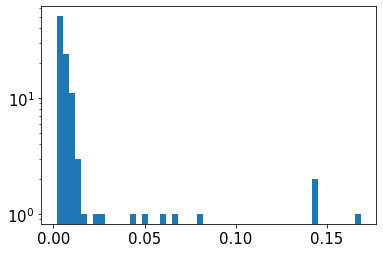

In [6]:
print(len(coords))
plt.close()
plt.hist(imgCovACov1[coords['pdet_y'],coords['pdet_x']],bins=50)
plt.yscale('log')
gc.collect()

10062

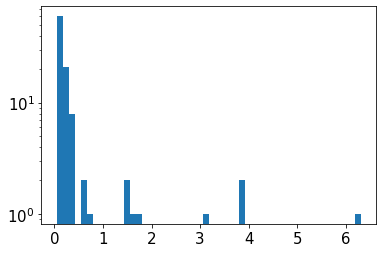

In [7]:
plt.close()
plt.hist(imgCov1[coords['pdet_y'],coords['pdet_x']],bins=50)
plt.yscale('log')
gc.collect()

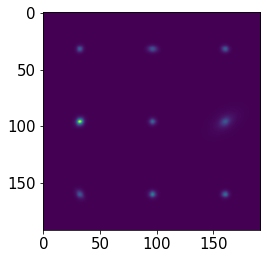

In [8]:
plt.imshow(img1[coords['pdet_y'][82]-96:coords['pdet_y'][82]+96,coords['pdet_x'][82]-96:coords['pdet_x'][82]+96])

In [9]:
print(coords['pdet_y'][82],coords['pdet_x'][82])

544 160


In [11]:
out1=pdet.get_shear_response(img1,psfData,gsigma=6*2*np.pi/64,coords=coords)
out2=pdet.get_shear_response(img2,psfData,gsigma=6*2*np.pi/64,coords=coords)
for j in range(1,4):
    for i in range(1,4):
        print(j,i)
        resEst=(out2['pdet_v%d%d' %(j,i)]-out1['pdet_v%d%d'%(j,i)])/0.04
        res=(out2['pdet_v%d%dr%d'%(j,i,ishear)]+out1['pdet_v%d%dr%d'%(j,i,ishear)])/2.
        print(np.average((res-resEst)/np.abs(resEst)),np.argmax(np.abs((res-resEst)/resEst)))
        print(np.max(np.abs((res-resEst)/resEst)))

1 1
0.00010602621921064939 98
0.006419819986216394
1 2
-0.0004914138487009862 39
0.018356963956405667
1 3
3.9734479418415695e-05 98
0.006927926423084964
2 1
0.00029216856983838247 92
0.006924395965418512
2 2
7.593829105688738e-05 98
0.004641215154109246
2 3
0.0002912399855473138 92
0.006912301570814832
3 1
4.3341523568507645e-05 98
0.006979587592574589
3 2
-0.0004893447704808616 39
0.018365487866435288
3 3
0.00010069349051468954 98
0.006410363144938051


In [9]:
out1['pdet_v22r1']

array([-3.35385172e-03, -5.19815985e-03,  1.85911334e-01, -1.00077268e-01,
       -1.33010686e-02,  8.06973484e-02,  2.97252473e-02, -5.96238024e-02,
        6.27024568e-02,  3.48810109e+00,  5.17709392e-02, -3.35645792e-02,
        2.12505525e-02,  8.47065310e-02, -1.01858617e-01, -4.82741547e-02,
        6.45548658e-02, -8.72116922e-02,  5.33562876e-02, -9.88342861e-02,
        5.13061384e-02,  1.99385539e-01,  8.61519318e-02,  1.79298440e-02,
        4.62409628e-03,  3.33915665e-02, -2.62206273e-02, -3.66156518e-01,
        3.04837829e-01,  7.41139155e-02,  4.47682457e-02,  2.06242741e-02,
        2.60342280e-01, -8.89987695e-02, -5.07774062e-01,  1.78498824e-02,
        1.80791048e-02,  2.27217288e-02, -1.29259030e-01,  2.33486925e-02,
        7.23935173e-02,  1.31710763e-01,  2.44577012e-01,  4.23015221e-02,
        5.51005302e-03,  6.21824261e-02,  1.09715500e-01, -4.25599680e-02,
       -4.54475641e-02, -2.66690091e-02, -2.51459550e-03, -6.18231074e-02,
       -6.22406589e-02, -

In [11]:
out1['pdet_v33r1']

array([-2.34399734e-03, -2.62648205e-03,  1.70082584e-01, -1.00067894e-01,
       -8.30269055e-03,  6.41336256e-02,  2.12598199e-02, -6.81753784e-02,
        3.51485983e-02,  2.40702054e+00,  3.72200982e-02, -2.14257906e-02,
        1.14339238e-02,  8.18836107e-02, -9.52012642e-02, -3.09410559e-02,
        3.48414122e-02, -4.67771574e-02,  2.74255492e-02, -8.36275465e-02,
        2.49508034e-02,  1.53756647e-01,  6.53578461e-02,  1.80599536e-02,
        1.99154022e-03,  1.99581784e-02, -2.49924564e-02, -2.85403437e-01,
        2.07899353e-01,  6.54452852e-02,  2.58131330e-02,  1.02224465e-02,
        1.89807986e-01, -6.18919042e-02, -4.13166076e-01,  1.24341131e-02,
        1.17969522e-02,  1.41752838e-02, -7.32339367e-02,  1.37638129e-02,
        4.12322456e-02,  9.92163054e-02,  2.33188333e-01,  3.24873484e-02,
        3.79631190e-03,  6.71883184e-02,  7.89235991e-02, -2.43232449e-02,
       -4.15701983e-02, -1.60878841e-02, -1.59057947e-03, -3.90048576e-02,
       -3.49535830e-02, -